In [1]:
import joblib
import pandas as pd
import numpy as np

# 选择需要归一化的列
columns_to_normalize_X = ['time_order', 'provincial_load_forecast', 'tie_line_load_forecast',
                        'total_power_forecast', 'new_energy_power_forecast',
                        'hydraulic_power_forecast', 'non_market_power_forecast']
columns_to_normalize_Y = ['dayahead_clearing_price']
# # 加载 scaler
scalerX = joblib.load('./data/scalerX.joblib')
scalerY = joblib.load('./data/scalerY.joblib')
data_train = pd.read_feather('./data/train_data.feather')
data_val = pd.read_feather('./data/val_data.feather')
data_test = pd.read_feather('./data/test_data.feather')

# 对上面的数据集进行归一化
data_train[columns_to_normalize_X] = scalerX.transform(data_train[columns_to_normalize_X])
data_test[columns_to_normalize_X] = scalerX.transform(data_test[columns_to_normalize_X])

data_train[columns_to_normalize_Y] = scalerY.transform(data_train[columns_to_normalize_Y])




In [2]:
trainX = data_train.iloc[:, 1:-1].values  # 前8列作为自变量
trainY = data_train.iloc[:, -1].values # 第9列作为因变量

testX = data_test.iloc[:, 1:-1].values  # 前8列作为自变量
testY = data_test.iloc[:, -1].values # 第9列作为因变量

In [4]:

# 最小二乘
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
# 创建最小二乘回归模型
model = LinearRegression()

# 拟合模型
model.fit(trainX, trainY)

# 获取模型的截距和系数
intercept = model.intercept_  # XGBoost模型没有截距
coefficients = model.coef_  # XGBoost模型没有系数

print("Intercept:", intercept)
print("Coefficients:", coefficients)  # XGBoost模型没有系数

predY = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）

mae = mean_absolute_error(trainY, predY)
rmse = np.sqrt(mean_squared_error(trainY, predY))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse, mae))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)
predY = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY)
rmse = np.sqrt(mean_squared_error(testY, predY))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))


Intercept: -0.06618283193236879
Coefficients: [ 0.12114226  0.0285131  -0.12565492 -0.18267085 -0.40992191 -0.16969735
  0.0103552 ]
Train RMSE: 0.7732, Train MAE: 0.6376
Test RMSE: 170.7490, Test MAE: 140.7526, Test MAPE: 83.4234


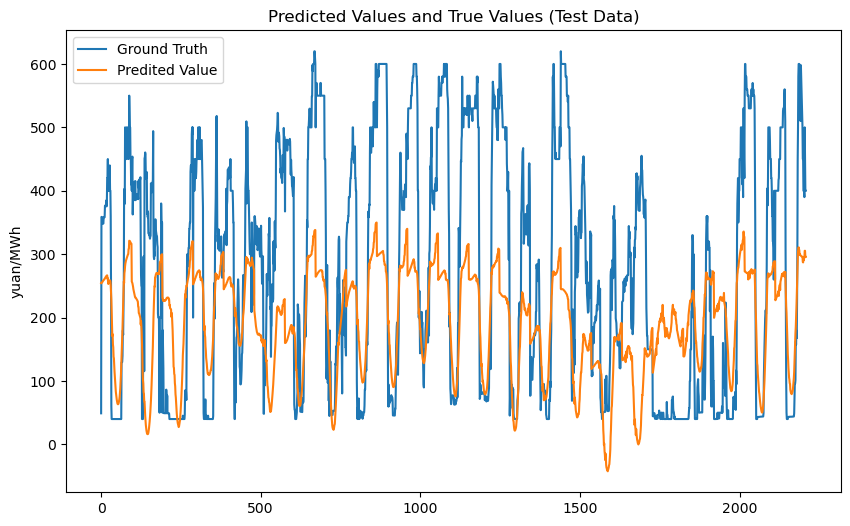

In [5]:
import matplotlib.pyplot as plt

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

Train RMSE: 1.4592, Train MAE: 1.1105
Test RMSE: 299.0365, Test MAE: 233.4868, Test MAPE: 100.9532


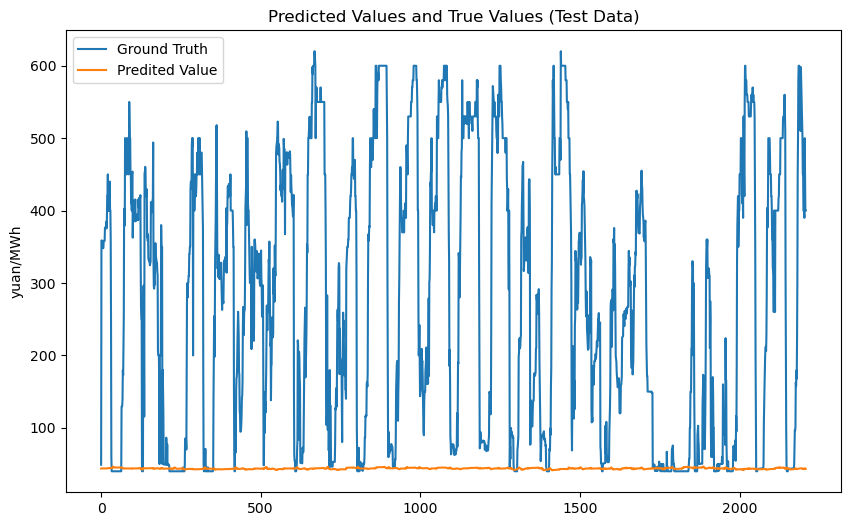

In [6]:
# RANSAC 回归（随机抽样一致性算法）
from sklearn.linear_model import RANSACRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


model = RANSACRegressor(max_trials=10000, residual_threshold=0.2)

# 拟合模型
model.fit(trainX, trainY)


# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 计算模型的在测试集上的性能指标（例如MAE、RMSE等）

predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY_test,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

Train RMSE: 0.5466, Train MAE: 0.3836
Test RMSE: 151.1290, Test MAE: 117.6509, Test MAPE: 100.2389


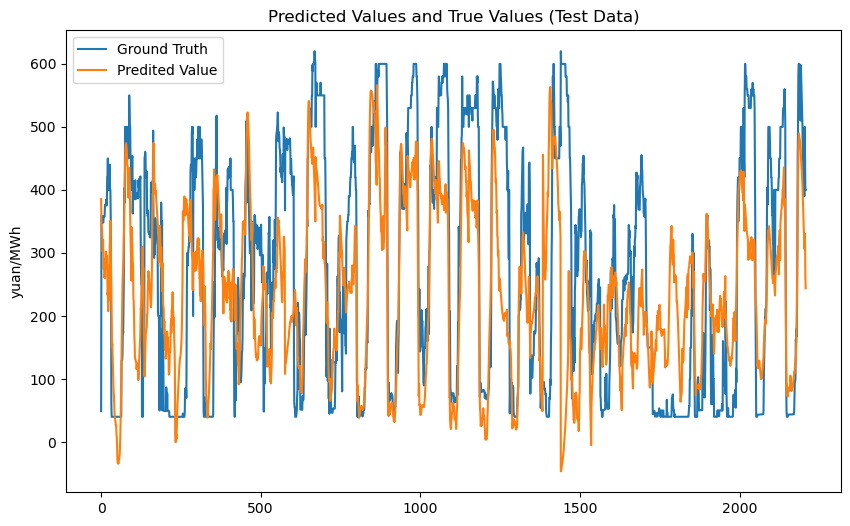

In [7]:
# SVR 回归（支持向量回归）
from sklearn.svm import SVR
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


model = SVR(C=10)

# 拟合模型
model.fit(trainX, trainY)



# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 计算模型的在测试集上的性能指标（例如MAE、RMSE等）

predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY_test,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

Train RMSE: 0.4475, Train MAE: 0.3381
Test RMSE: 143.5724, Test MAE: 112.7088, Test MAPE: 100.3661


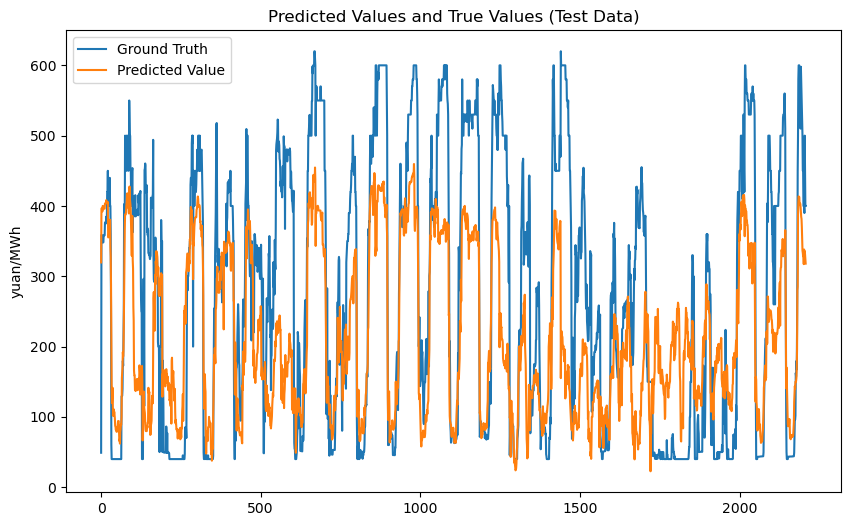

In [8]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 创建 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# 拟合模型
model.fit(trainX, trainY)

# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型在训练集上的性能指标
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 反归一化测试集预测结果
predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()

# 计算模型在测试集上的性能指标
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# 绘制测试数据的真实值与预测值
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Ground Truth')
plt.plot(predY_test, label='Predicted Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()


Train RMSE: 0.2547, Train MAE: 0.1786
Test RMSE: 145.5783, Test MAE: 114.6100, Test MAPE: 100.3121


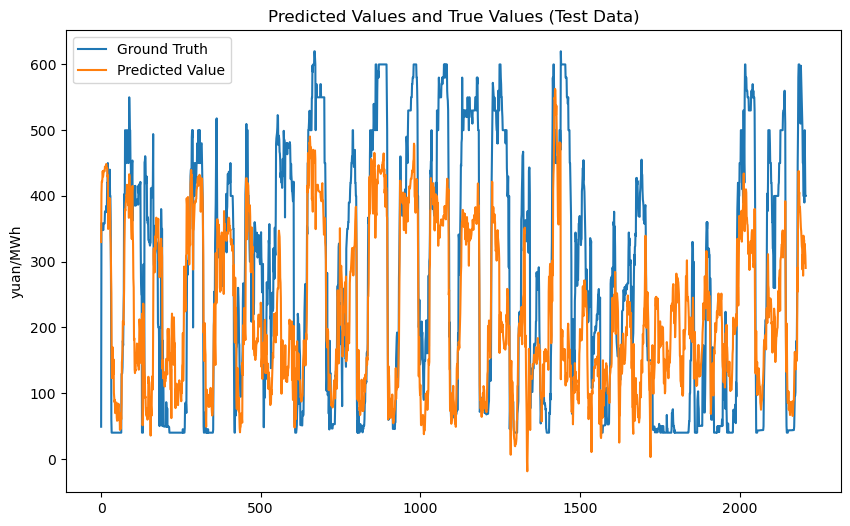

In [9]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 创建 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1)

# 拟合模型
model.fit(trainX, trainY)

# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型在训练集上的性能指标
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 反归一化测试集预测结果
predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()

# 计算模型在测试集上的性能指标
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# 绘制测试数据的真实值与预测值
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Ground Truth')
plt.plot(predY_test, label='Predicted Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()


In [36]:
scalerY.mean_

array([217.41885241])

In [37]:
scalerY.var_

array([23098.40412116])